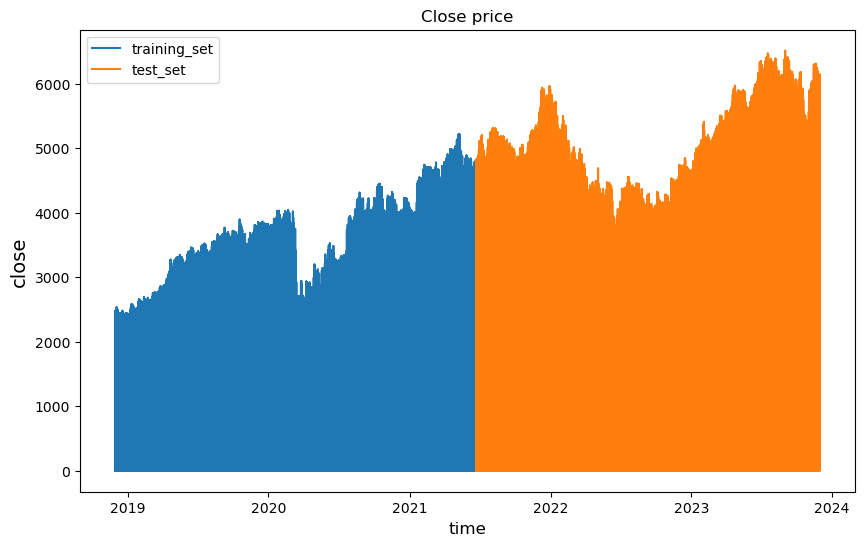

C:\Users\pgpau\AppData\Local\Temp\ipykernel_26336\1842600724.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff(1)


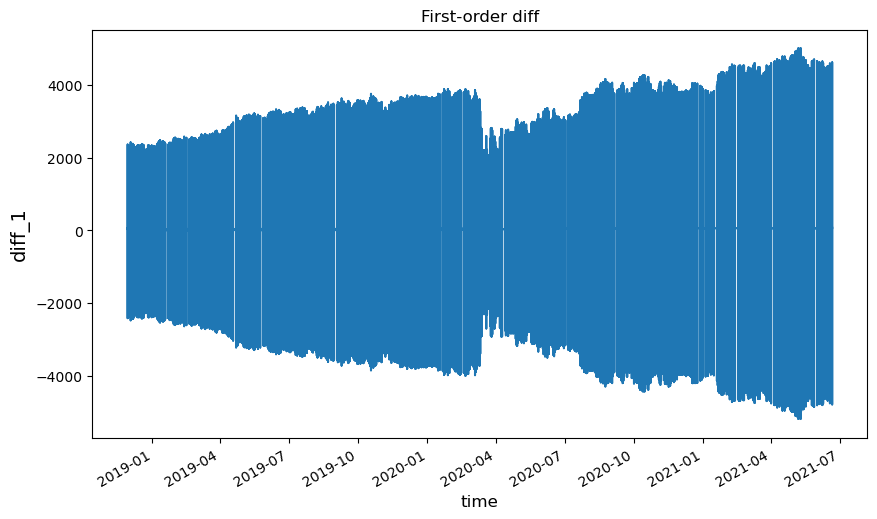

C:\Users\pgpau\AppData\Local\Temp\ipykernel_26336\1842600724.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


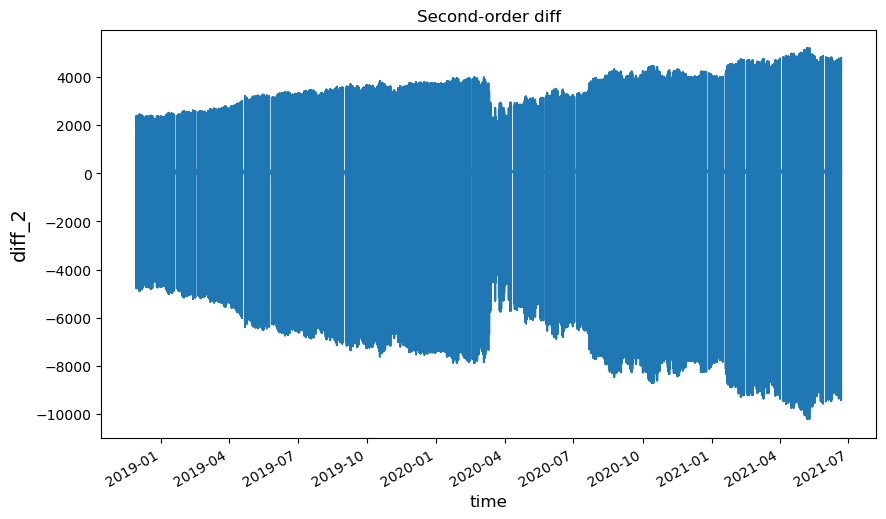

        lb_stat  lb_pvalue       bp_stat  bp_pvalue
1  77677.122903        0.0  77676.354768        0.0
2  77794.544107        0.0  77793.774424        0.0


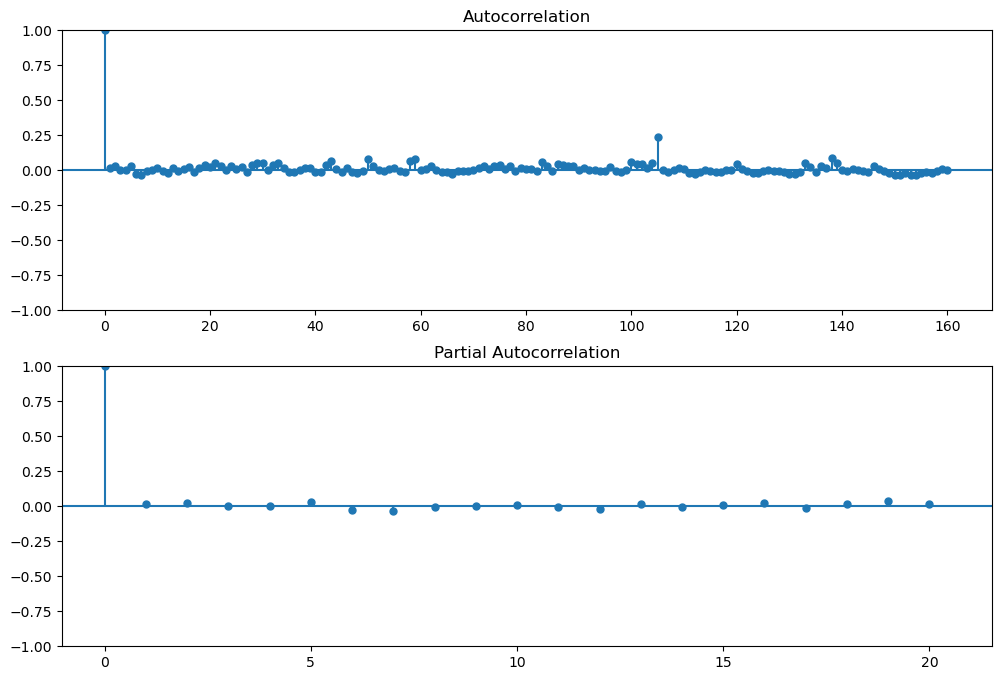

&                           close
Date                           
2018-11-29 05:00:00   61.552624
2018-11-29 05:00:00  -49.907131
2018-11-29 05:00:00   28.949497
2018-11-29 05:00:00  -44.640644
2018-11-29 05:00:00   99.642139
...                         ...
2021-06-21 04:00:00   -6.871563
2021-06-21 04:00:00    8.592602
2021-06-21 04:00:00  102.957123
2021-06-21 04:00:00 -117.956299
2021-06-21 04:00:00   69.705917

[303371 rows x 1 columns]


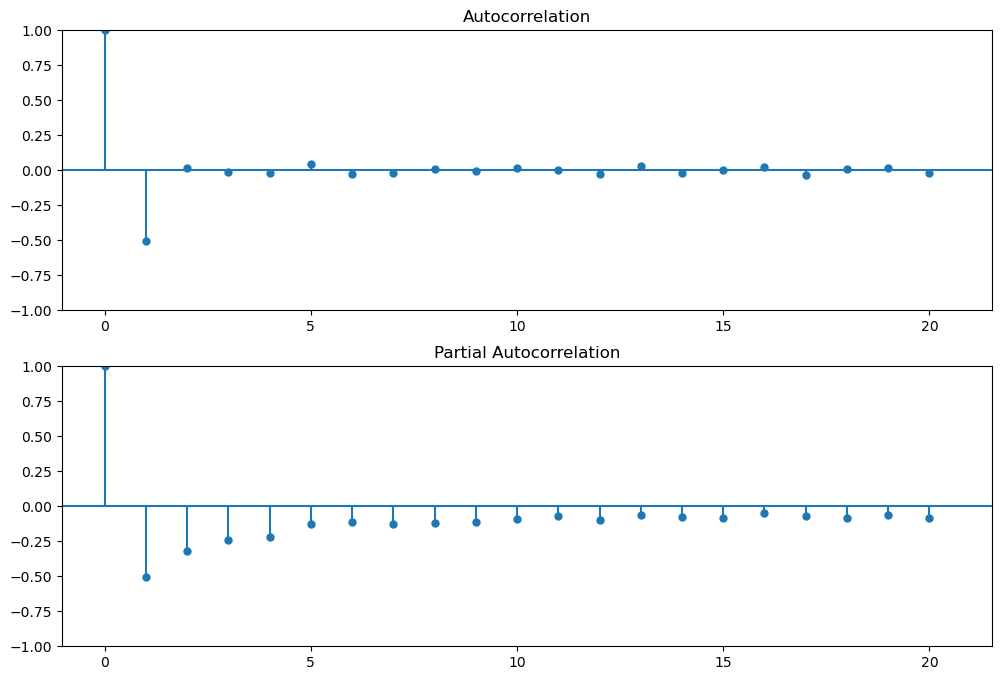

C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics
from utils import *
import statsmodels.api as sm

data = pd.read_csv('stock_details_5_years.csv')
test_set2 = data.loc[3501:, :] 
data.index = pd.to_datetime(data['Date'], errors='coerce', utc=True).dt.tz_localize(None)
data = data.drop([c for c in ['ts_code','Date'] if c in data.columns], axis=1)

close_candidates = [c for c in data.columns if str(c).lower().replace(" ", "") in {"close","adjclose","adj_close","adjclose*","closingprice","closeprice"}]
if "close" not in data.columns and close_candidates:
    data = data.rename(columns={close_candidates[0]: "close"})

data = pd.DataFrame(data.apply(pd.to_numeric, errors='coerce'), dtype=np.float64)

training_set = data.loc['2007-01-04':'2021-06-21', :]
test_set = data.loc['2021-06-22':, :]

plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='training_set')
plt.plot(test_set['close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

temp = np.array(training_set['close'])

training_set['diff_1'] = training_set['close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()

training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

temp1 = np.diff(training_set['close'], n=1)

training_data1 = training_set['close'].diff(1)
temp2 = np.diff(training_set['close'], n=1)
print(acorr_ljungbox(temp2, lags=2, boxpierce=True))

acf_pacf_plot(training_set['close'],acf_lags=160)

price = list(temp2)
data2 = {
    'Date': training_set['diff_1'].index[1:], 
    'close': price
}

df = pd.DataFrame(data2)
df['Date'] = pd.to_datetime(df['Date'])

training_data_diff = df.set_index(['Date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)

model = sm.tsa.ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()

history = [x for x in training_set['close']]
predictions = list()
for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = float(yhat[0])
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]
    history.append(obs)

predictions1 = {
    'Date': test_set.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['Date'], drop=True)
predictions1.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

model2 = sm.tsa.ARIMA(endog=data['close'], order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')
evaluation_metric(test_set['close'],predictions)
adf_test(temp)
adf_test(temp1)

predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3479:]
print('#', predictions_ARIMA_diff)
plt.figure(figsize=(10, 6))
plt.plot(training_data_diff, label="diff_1")
plt.plot(predictions_ARIMA_diff, label="prediction_diff_1")
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.title('DiffFit')
plt.legend()
plt.show()
